## Import Library

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

np.random.seed(500)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Dataset and take a Quick Look

In [2]:
url = "https://raw.githubusercontent.com/henrywan910/Machine-Learning/main/train.csv"
df = pd.read_csv(url)
df

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal
...,...,...
29987,originsmp originssmp,Normal
29988,name muhammad asif farooqi im pakistan amp sta...,Lonely
29989,moms mad wont go overnight skiing trip 5 peopl...,Stressed
29990,even tonight youre go bed date someone cannot ...,Normal


In [ ]:
df.head()

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal


In [ ]:
# df = df[(df["labels"]=="Anxious") | (df["labels"]=="Lonely")]

In [ ]:
#df = df.drop_duplicates("tweets")

In [ ]:
df.info()
# there are 29,992 instances in the dataset. Noted that there are no attributes having null values.
# All attributes are strings. And no need to convert any attributes to numercial.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29992 entries, 0 to 29991
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  29992 non-null  object
 1   labels  29992 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [ ]:
df["labels"].value_counts()
# The label attribute seems to be balanced.

Anxious     8388
Normal      7976
Stressed    6840
Lonely      6788
Name: labels, dtype: int64

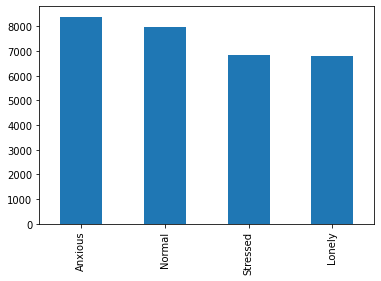

In [ ]:
df["labels"].value_counts().plot(kind="bar")

In [ ]:
df["tweets"].value_counts()
# There are some duplicated tweets 

human need job cant exist amp make art chill cat                                             352
sad thing disinformation truth come damage already people already mi                         334
sad newscloris insanely talented could make laugh cry drop hat always pleasure               267
feel like im start scratch every aspect life kinda sad kinda powerful kinda necessary        262
advisor tell instead try game market need put money 1 tall bank shape li                     235
                                                                                            ... 
petty self anymore im tire try reach help im gonna give sinc                                   1
carrano perfectly capable get anonymous twitterig account share noxious opinion choose n       1
literally iconic                                                                               1
im tire patient                                                                                1
even tonight youre go bed date

In [ ]:
tweet_unique = sum(df["tweets"].value_counts() == 1)
tweet_dup = sum(df["tweets"].value_counts() >1)
print(f"unique tweet % = {tweet_unique/(tweet_unique+tweet_dup)*100}")
print(f"duplicated tweet % = {tweet_dup/(tweet_unique+tweet_dup)*100}")


unique tweet % = 70.3799975244461
duplicated tweet % = 29.620002475553903


In [ ]:
df[df["tweets"].str.contains("advisor tell instead try")]["labels"].value_counts()
# for duplicate tweets, labeling in some tweets are different

Lonely     120
Anxious    115
Name: labels, dtype: int64

In [ ]:
df[df["tweets"].str.contains("human need job")]["labels"].value_counts()
# for duplicate tweets, labeling in some tweets are different

Lonely     177
Anxious    175
Name: labels, dtype: int64

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df['tweets'],df['labels'],test_size=0.2)

In [4]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)



In [5]:
Encoder.classes_

array(['Anxious', 'Lonely', 'Normal', 'Stressed'], dtype=object)

## Data Prepoccessing 


1.   Remove Blank rows in Data, if any
2.   Change all the text to lower case
3.Word Tokenization
4.Remove Stop words
5.Remove Non-alpha text
6.Word Lemmatization

In [20]:
#What is Tokenization? 
s = df["tweets"][29990]
print(s)
print(word_tokenize(s))

even tonight youre go bed date someone cannot see future wawu 
['even', 'tonight', 'youre', 'go', 'bed', 'date', 'someone', 'can', 'not', 'see', 'future', 'wawu']


In [ ]:
df

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal
...,...,...
29987,originsmp originssmp,Normal
29988,name muhammad asif farooqi im pakistan amp sta...,Lonely
29989,moms mad wont go overnight skiing trip 5 peopl...,Stressed
29990,even tonight youre go bed date someone cannot ...,Normal


In [28]:
class TweetToWordTransformer(BaseEstimator,TransformerMixin):
  def __init__(self, dropna=True, lower_case=True, tokenize=True):
    self.dropna = dropna
    self.lower_case = lower_case
    self.tokenize = tokenize
  def fit(self, X, y=None):
    return self
  def transform(self, X):
   # if self.dropna:
   #   X.dropna(inplace=True)
    if self.lower_case:
      X = [entry.lower() for entry in X]
    if self.tokenize:
      X = [word_tokenize(entry) for entry in X]
    
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    X_transformed = []
    for index,entry in enumerate(X):
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
        X_transformed.append(str(Final_words))
      
    return np.array(X_transformed)


In [29]:
tweet2word = TweetToWordTransformer()
X_train_transformed = tweet2word.transform(X_train)

In [40]:
print(X_train[-20:-1])

14952    human need job cant exist amp make art chill cat 
8294                                         next year de 
7309                                              mat rou 
12947    ok something need change cant tire constantly ...
24594    sad many people think normal acceptable behavi...
16554    im live twitch continue first playthrough bloo...
20265    werent minister senior housing announce 1500 s...
14549                             im sad today thats okay 
5521     senior aide new york governor andrew cuomo apo...
21229                           think need mctominay game 
4941     youre dumb people class confuse obviously hard...
19967                                    use lot argument 
20295                      president trumps defense clear 
16968    also enough good slightly good heroku heroku n...
20767                                      yes need teach 
19389                        mad tracy beaker live eccles 
3790     cfb9dfe2 battle id need backup lvl 150 proto b.

In [41]:
print(X_train_transformed[-20:-1])

["['human', 'need', 'job', 'cant', 'exist', 'amp', 'make', 'art', 'chill', 'cat']"
 "['next', 'year', 'de']" "['mat', 'rou']"
 "['ok', 'something', 'need', 'change', 'cant', 'tire', 'constantly', 'juicing', 'caffeine', 'practical', 'anymore', 'weak']"
 "['sad', 'many', 'people', 'think', 'normal', 'acceptable', 'behavior', 'doom', 'really', 'wha']"
 "['im', 'live', 'twitch', 'continue', 'first', 'playthrough', 'bloodborne', 'last', 'time', 'take', 'bloodstarved', 'beast', 'toni']"
 "['werent', 'minister', 'senior', 'housing', 'announce', 'senior', 'die', 'alone', 'watch', 'yet', 'address', 'public', 'firetheucp']"
 "['im', 'sad', 'today', 'thats', 'okay']"
 "['senior', 'aide', 'new', 'york', 'governor', 'andrew', 'cuomo', 'apologize', 'democratic', 'lawmaker', 'withhold', 'death', 'toll']"
 "['think', 'need', 'mctominay', 'game']"
 "['youre', 'dumb', 'people', 'class', 'confuse', 'obviously', 'hard', 'message', 'teacher', 'say', 'youve', 'coursework', 'youre', 'stick', 'progress', 'cou

Transform the features


1.   tweet to word
2.   word to vector



In [42]:
preprocess_pipeline = Pipeline([
    ("tweet_to_word", TweetToWordTransformer()),
    ("word_to_vector", TfidfVectorizer(max_features=50000)),
])

In [43]:
X_train_transformed = preprocess_pipeline.fit_transform(X_train)

<function sklearn.feature_extraction.text._VectorizerMixin.get_stop_words>

## Model Selection

# Naive Bayes

In [50]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()

NB_scores = cross_val_score(Naive, X_train_transformed, y_train, cv=10)
NB_scores.mean()

0.5482011602056411

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_transformed = preprocess_pipeline.transform(X_test)

Naive.fit(X_train_transformed, y_train)

y_pred_NB = Naive.predict(X_test_transformed)

# Print the confusion matrix
confmx_NB = confusion_matrix(y_test, y_pred_NB)
print(confmx_NB)

# Print the precision and recall, among other metrics
report_NB = classification_report(y_test, y_pred_NB, digits=3)
print(report_NB)

[[1172  451   55   26]
 [1128  189   43   17]
 [ 597   30  805  147]
 [ 188    4   77 1070]]
              precision    recall  f1-score   support

           0      0.380     0.688     0.489      1704
           1      0.280     0.137     0.184      1377
           2      0.821     0.510     0.629      1579
           3      0.849     0.799     0.823      1339

    accuracy                          0.539      5999
   macro avg      0.583     0.533     0.532      5999
weighted avg      0.578     0.539     0.531      5999



In [ ]:
Encoder.classes_

# SVM

In [52]:
from sklearn.model_selection import cross_val_score
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

SVM_scores = cross_val_score(SVM, X_train_transformed, y_train, cv=10)
SVM_scores.mean()

0.6540233256912604

In [53]:
# Classifier - Algorithm - SVM
X_test_transformed = preprocess_pipeline.transform(X_test)

# fit the training dataset on the classifier

SVM.fit(X_train_transformed,y_train)

# predict the labels on validation dataset
y_pred_SVM = SVM.predict(X_test_transformed)

# Print the confusion matrix
confmx_SVM = confusion_matrix(y_test, y_pred_SVM)
print(confmx_SVM)

# Print the precision and recall, among other metrics
report_SVM = classification_report(y_test, y_pred_SVM, digits=3)
print(report_SVM)




[[ 781  807  102   14]
 [ 923  391   50   13]
 [ 105   37 1421   16]
 [  29   10   59 1241]]
              precision    recall  f1-score   support

           0      0.425     0.458     0.441      1704
           1      0.314     0.284     0.298      1377
           2      0.871     0.900     0.885      1579
           3      0.967     0.927     0.946      1339

    accuracy                          0.639      5999
   macro avg      0.644     0.642     0.643      5999
weighted avg      0.638     0.639     0.638      5999



# SGD

In [54]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# Classifier - Algorithm - SGD
# fit the training dataset on the classifier
SGD = SGDClassifier()

SGD_scores = cross_val_score(SGD, X_train_transformed, y_train, cv=10)
SGD_scores.mean()

y_train_pred_SGD = cross_val_predict(SGD, X_train_transformed, y_train, cv=3)
confmx_train_SGD = confusion_matrix(y_train,y_train_pred_SGD)

print(SGD_scores.mean())
print(confmx_train_SGD)

0.6539401313047103
[[3498 2404  658  124]
 [3385 1464  484   78]
 [ 227   76 6001   93]
 [  42   13  414 5032]]


In [ ]:
cl_a, cl_b = 0,1
X_aa = X_train[(y_train==cl_a)&(y_train_pred_SGD==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred_SGD==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred_SGD==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred_SGD==cl_b)]


In [ ]:
X_aa[:25]

26948    read bible every day astound people quote chap...
17590    im sorry hear need help could get take care iv...
14508    ta okay okay mental health act character dont ...
8332     need last tomorrow work want either cuck finsu...
11394    guys please help polish government make aborti...
24269             whoever end go lucky get much love give 
29110    happy share ive donate 10000 provide medical a...
21516       e1bf3279 battle id need backup lvl 120 avatar 
23758    want summer light cause need till sun go ill p...
13821                     wyd outside wall alone babygirl 
17073    ive get mtn mike royce stock need give oni sha...
7818     love many people come talk private thing may e...
29548    im okay everyone im emotionally burn get break...
10268    need moot tweet count help jebal im ask much e...
10838    ask associate come help yell hell dont feel co...
469                        need fix sleeping schedule 3am 
16401               listen anyone class im go need sketc

In [ ]:
X_ab[:25]

25800    well finish guardian need something else watch...
29572    okay guess conversation character x need annou...
17026    human need job cant exist amp make art chill cat 
14692                 say drive alone forever past street 
6226       definitely warcraft need see nick role playing 
11951    tw holocaust today holocaust memorial day bare...
16781    really want cool like everyone use lot substan...
21830    explain gift thing way people understand fanba...
15962    eng sub minnie tease miyeonand puppy sister ma...
12280                        know arent confuse need cuck 
19549    ok curse kid beat kid belittle threaten kid ya...
5314     dont know yampy tell ann stokes make thing cus...
16808                                          need money 
20779                  love alone time actually necessity 
874      advisor tell instead try game market need put ...
27586    human need job cant exist amp make art chill cat 
1907                          dont say love fifth harmon

In [ ]:
X_test_transformed = preprocess_pipeline.transform(X_test)

# fit the training dataset on the classifier

SGD.fit(X_train_transformed,y_train)

# predict the labels on validation dataset
y_pred_SGD = SGD.predict(X_test_transformed)

# Print the confusion matrix
confmx_SGD = confusion_matrix(y_test, y_pred_SGD)
print(confmx_SGD)

# Print the precision and recall, among other metrics
report_SGD = classification_report(y_test, y_pred_SGD, digits=3)
print(report_SGD)


[[ 479   75  121   12]
 [ 203   74   86    8]
 [  55   26 1360   23]
 [   3    0   83  624]]
              precision    recall  f1-score   support

     Anxious      0.647     0.697     0.671       687
      Lonely      0.423     0.199     0.271       371
      Normal      0.824     0.929     0.873      1464
    Stressed      0.936     0.879     0.906       710

    accuracy                          0.785      3232
   macro avg      0.707     0.676     0.681      3232
weighted avg      0.765     0.785     0.769      3232



Look Deeper

ValueError: ignored

In [ ]:
(y_train==cl_a).s

array([False,  True, False, ..., False, False, False])

In [ ]:
X_aa[10]

# RandomForest (Dont run it, it takes 30mins)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest_scores = cross_val_score(forest, X_train_transformed, y_train, cv=10)
forest_scores.mean()


In [ ]:
X_test_transformed = preprocess_pipeline.transform(X_test)

# fit the training dataset on the classifier

forest.fit(X_train_transformed,y_train)

# predict the labels on validation dataset
y_pred_forest =forest.predict(X_test_transformed)

# Print the confusion matrix
confmx_forest = confusion_matrix(y_test, y_pred_forest)
print(confmx_forest)

# Print the precision and recall, among other metrics
report_forest = classification_report(y_test, y_pred_forest, digits=3)
print(report_forest)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, NB_scores, ".")
plt.plot([2]*10, SVM_scores, ".")
plt.plot([3]*10, SGD_scores, ".")
plt.plot([4]*10, forest_scores, ".")
plt.boxplot([NB_scores, SVM_scores, SGD_scores, forest_scores], labels=("Naive Bayes","SVM", "SGD", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [ ]:

from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(
    estimators=[('SVM', SVM), ('NB', Naive)],
    voting='hard')

voting_clf.fit(X_train_Tfidf, y_train)


# predict the labels on validation dataset
y_pred_vot = voting_clf.predict(X_test_Tfidf)
# Use accuracy_score function to get the accuracy
print("voting Accuracy Score -> ",accuracy_score(y_pred_vot, y_test)*100)


## Jimmy Testing

In [ ]:
j_test = ['I am sad', 'I am depressed']
j_pd = pd.DataFrame(j_test)
j_pd.columns = ['tweets']
j_pd.to_csv('./j.csv')

In [ ]:
df = pd.read_csv('./j.csv',encoding='latin-1', index_col=[0])
df.head()

In [ ]:
df['tweets']

In [ ]:
#Voting
from sklearn.ensemble import VotingClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10)
# create the sub models
estimators = []
model1 = Naive
estimators.append(('NB', model1))
model2 = SVM
estimators.append(('svm', model2))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X_train_Tfidf,y_train, cv=kfold)
print("Accuracy for VotingClassifier:", results.mean()*100)